In [1]:
import pandas as pd 
import numpy as np
import re
import spacy
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud
from wordcloud import WordCloud
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from spacy.lang.en.stop_words import STOP_WORDS as sw
import json

In [2]:
emotion = pd.read_csv('C:/res/text_to_emotion.csv')
emotion.head(5)

,text,emotion
0,i feel cold,ANGER
1,i feel the cold i can say he sends it,ANGER
2,i remember feeling like my blood had run cold ...,ANGER
3,i hate too is stepping outside in the cold and...,ANGER
4,i don't think i am anti social i just don't re...,ANGER


In [3]:
fill = open('contract_words.json','r')
contract_words = json.load(fill)
fill.close

<function TextIOWrapper.close()>

In [4]:
def cont_to_exp(x):
    if type(x) is str:
        for key in contract_words:
            value =contract_words[key]
            x = x.replace(key, value)
        return x
    else:
        return x

In [5]:
def lower_case(x):
    x = str(x).lower()
    return x

In [6]:
def remove_url(x):
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)
    return x

In [7]:
def remove_char_punc(x):
    x = re.sub(r'[^\w]+'," ",x)
    return x

In [8]:
nlp = spacy.load('en_core_web_lg')

In [9]:
def make_to_base(x):
    x = str(x)
    x_list = []
    doc = nlp(x)
    
    for token in doc:
        lemma = token.lemma_
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text

        x_list.append(lemma)
    return ' '.join(x_list)

In [10]:
emotion['text'] = emotion['text'].apply(lambda x:cont_to_exp(x))

In [11]:
emotion['text'] = emotion['text'].apply(lambda x:remove_char_punc(str(x)))

In [12]:
emotion['text'] = emotion['text'].apply(lambda x: lower_case(x))

In [13]:
emotion['text'] = emotion['text'].apply(lambda x: remove_url(x))

In [14]:
emotion['text'] = emotion['text'].apply(lambda x: make_to_base(x))

# Building function on word2vec embedding


In [15]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

In [16]:
emotion['vec'] = emotion['text'].apply(lambda x: get_vec(x)) 


# Training models

In [17]:
y = emotion['emotion']

In [18]:
x = emotion['vec'].values

In [19]:
x = x.reshape(-1, 1)

In [20]:
x = np.concatenate(np.concatenate(x, axis = 0),axis = 0).reshape(-1,300)

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.20,stratify = y)

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
lr = LogisticRegression(solver = 'liblinear', n_jobs = -1)

In [24]:
penalty = (['l1','l2'])
max_iter = [100,500]

In [25]:
hyperparameters = dict(penalty = penalty, max_iter= max_iter)

In [26]:
clf = GridSearchCV(lr, hyperparameters, cv = None, n_jobs = -1)

In [27]:
clf.fit(x_train,y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


GridSearchCV(estimator=LogisticRegression(n_jobs=-1, solver='liblinear'),
             n_jobs=-1,
             param_grid={'max_iter': [100, 500], 'penalty': ['l1', 'l2']})

In [28]:
y_pred = clf.predict(x_test)

# printing the accuracy on the testing dataset

In [29]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

       ANGER       0.78      0.74      0.76      1060
        FEAR       0.84      0.87      0.86       968
         JOY       0.84      0.86      0.85       974
        LOVE       0.94      0.92      0.93      1017
     SADNESS       0.81      0.86      0.83       950
    SURPRISE       0.91      0.88      0.89      1031

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000



# Printing the best parameters

In [30]:
print(f'best param = {clf.best_params_}\n best score =  {clf.best_score_}' )

best param = {'max_iter': 500, 'penalty': 'l1'}
 best score =  0.8567083333333334


In [31]:
def get_pred(x):
    x = cont_to_exp(x)
    x = remove_url(x)
    x = make_to_base(x)
    x = lower_case(x)
    x = remove_char_punc(x)
    vec = get_vec(x).reshape(1,-1)
    vec = vec.reshape(1,300)
    y_pred = clf.predict(vec)
    return y_pred

In [32]:
x = "You behave so irritating"

In [33]:
get_pred(x)

array(['ANGER'], dtype=object)

In [34]:
emotion['emotion'].value_counts()

JOY         5000
LOVE        5000
SURPRISE    5000
FEAR        5000
SADNESS     5000
ANGER       5000
Name: emotion, dtype: int64

In [35]:
def word_plot(x):
    Ws = WordCloud(width = 500,height = 400).generate(str(x))
    plt.imshow(Ws)
    plt.show()

# Grouping the Emotions For Easy WordCloud Generating

In [36]:
anger = (emotion.loc[emotion['emotion']=='ANGER'])

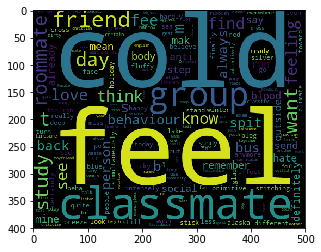

In [37]:
word_plot(anger['text'])

In [38]:
SAD = (emotion.loc[emotion['emotion']=='SADNESS'])

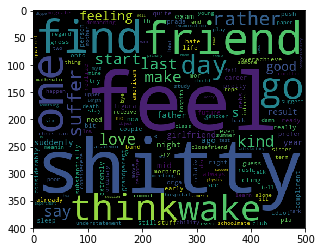

In [39]:
word_plot(SAD['text'])

In [40]:
JOY = (emotion.loc[emotion['emotion']=='JOY'])

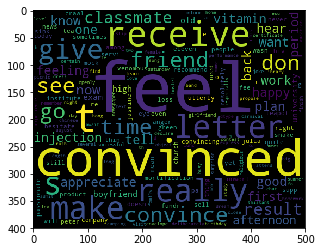

In [41]:
word_plot(JOY['text'])

In [42]:
Fear = (emotion.loc[emotion['emotion']=='FEAR'])

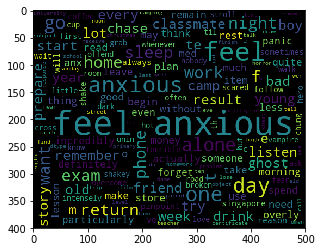

In [43]:
word_plot(Fear['text'])

In [44]:
surprise = (emotion.loc[emotion['emotion']=='SURPRISE'])

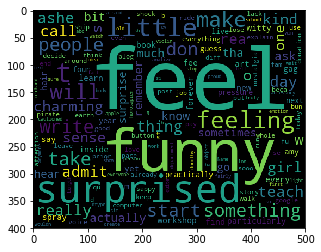

In [45]:
word_plot(surprise['text'])

## Saving and loading my model

In [46]:
import pickle

In [47]:
pickle.dump(clf,open('emotion.pkl','wb'))

In [48]:
model = pickle.load(open('emotion.pkl','rb'))

### Saving and Loading the predicting parameter

In [49]:
pickle.dump(get_pred,open('get_pred.pkl','wb'))

In [50]:
predict = pickle.load(open('get_pred.pkl','rb'))

# Testing my predicting parameter

In [51]:
x = ' i hate you'

In [52]:
predict(x)

array(['ANGER'], dtype=object)